# Take Home Assignment: Rooftop classifier investigation of satellite imagery

# Image processing and visualisation

1. (a) Open the image using rasterio and convert it to a numpy array.

In [28]:
# !pip install rasterio

# after running this restart the kernel and move to the next cell and comment the line above

In [29]:
# import the needed library
from rasterio import open as rOpen

In [30]:
with rOpen('data/train/train_input.tif', 'r') as training_input_ds:
    training_input_image_ndarray = training_input_ds.read()

del training_input_ds # clean up objects

1. (b) Print the array shape and type

In [31]:
print(f"Array shape: {training_input_image_ndarray.shape}")
print(f"Array type: {training_input_image_ndarray.dtype}")

Array shape: (8, 650, 650)
Array type: uint16


1. (c) Given that that the array dimensions are in the form (channels, height, width), normalize each
channel using min/max normalization. Your normalization code will be reused later.

In [32]:
# import the needed library
import numpy as np

In [33]:
# could have rewritten this as a function

def normalize_input_image(input_to_be_normalized, training_input):
    per_channel_max = np.max(training_input, axis=1, keepdims=True)
    per_channel_min = np.min(training_input, axis=1, keepdims=True)

    normalized_input_2D = (input_to_be_normalized - per_channel_min)/(per_channel_max - per_channel_min)
    
    return normalized_input_2D



training_input_image_ndarray_2D = np.reshape(training_input_image_ndarray, (8, -1))

normalised_training_input_2D = normalize_input_image(training_input_image_ndarray_2D, training_input_image_ndarray_2D)
normalised_training_input_image_ndarray = np.reshape(normalised_training_input_2D, (8, 650, 650))


1. (d) Visualize the red, green and blue channels of the normalized array as an RGB image.

In [34]:
# !python3 -m pip install --upgrade pip
# !python3 -m pip install--upgrade Pillow
# !pip install matplotlib

# after running this restart the kernel and move to the next cell and comment the line above

In [35]:
# import the needed library
from matplotlib import pyplot as plt

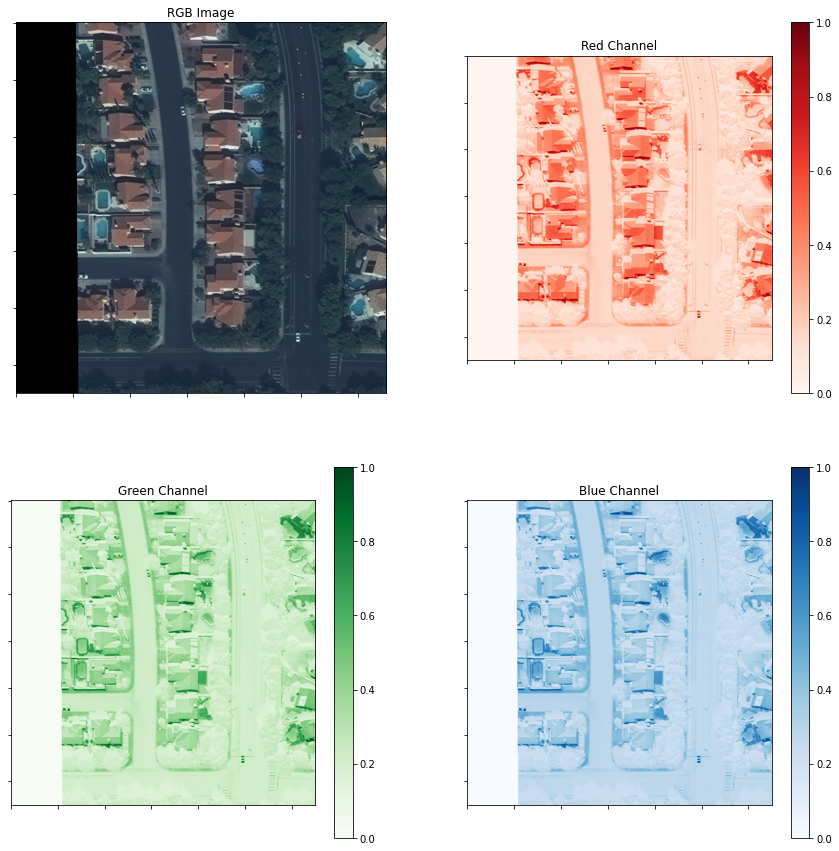

In [36]:
normalised_red_channel_train = normalised_training_input_image_ndarray[4]
normalised_green_channel_train = normalised_training_input_image_ndarray[2]
normalised_blue_channel_train = normalised_training_input_image_ndarray[1]



normalised_rgb_train_ndarray = np.dstack(
    (
        normalised_red_channel_train,
        normalised_green_channel_train,
        normalised_blue_channel_train
    )
)

fig, axs = plt.subplots(2,2,figsize=(15,15))

rgb_subplot = axs[0,0].imshow(normalised_rgb_train_ndarray)
axs[0,0].xaxis.set_major_formatter(plt.NullFormatter())  # remove the xlabels
axs[0,0].yaxis.set_major_formatter(plt.NullFormatter())  # remove the ylabels
axs[0,0].title.set_text('RGB Image')

rChannel_subplot = axs[0,1].imshow(normalised_red_channel_train, cmap='Reds')
fig.colorbar(rChannel_subplot, ax=axs[0,1])
axs[0,1].xaxis.set_major_formatter(plt.NullFormatter())
axs[0,1].yaxis.set_major_formatter(plt.NullFormatter())
axs[0,1].title.set_text('Red Channel')

gChannel_subplot = axs[1,0].imshow(normalised_green_channel_train, cmap='Greens')
fig.colorbar(gChannel_subplot, ax=axs[1,0])
axs[1,0].xaxis.set_major_formatter(plt.NullFormatter())
axs[1,0].yaxis.set_major_formatter(plt.NullFormatter())
axs[1,0].title.set_text('Green Channel')


bChannel_subplot = axs[1,1].imshow(normalised_blue_channel_train, cmap='Blues')
fig.colorbar(bChannel_subplot, ax=axs[1,1])
axs[1,1].xaxis.set_major_formatter(plt.NullFormatter())
axs[1,1].yaxis.set_major_formatter(plt.NullFormatter())
axs[1,1].title.set_text('Blue Channel')

plt.show()

# Logistic Regression

2. (a) Using your favourite ML package, train a binary logistic regression on the training images. Your
model should take as input a min/max normalized 8-band input pixel and predict the
corresponding value of the single-channel target pixel.

In [37]:
# !pip install scikit-learn

# after running this restart the kernel and move to the next cell and comment the line above

In [38]:
# get the training targets/labels

with rOpen('data/train/train_target.tif', 'r') as training_target_ds:
    training_target_image_ndarray = training_target_ds.read()  

del training_target_ds # clean up memory

# rescale the labels to be either 0 or 1 instead of 0 or 255
cleaned_training_target_image_ndarray = training_target_image_ndarray.copy() / 255

# make the training data 2D and transpose it to be of shape (number of samples, number of features)
logistic_train_data_before_transpose = np.reshape(normalised_training_input_image_ndarray, (8, -1))
logistic_train_data = logistic_train_data_before_transpose.T

# convert the shape from (1,650,650) to (650*650 =  422500)
logistic_train_target = np.reshape(cleaned_training_target_image_ndarray, (650 * 650))

In [39]:
# train the logistic regression model
from sklearn.linear_model import LogisticRegression
logisticRegression_sklearn = LogisticRegression(random_state=0, solver='lbfgs').fit(logistic_train_data, logistic_train_target)

# logistic regression parameter
# possible way to improve
# logisticRegression_sklearn_improved = LogisticRegression(random_state=0, solver='lbfgs', class_weight='balanced').fit(logistic_train_data, logistic_train_target)


Additional comments: In the rough python file attached I show a run through of the various thoughts I had when it came to choosing an appropriate logistic regression package. For example, in it is code for using keras to create a logistic regression model. I ended up choosing sklearn due to it's performance

2. (b) How many trainable parameters does your logistic regression model have? Describe your
calculation.

The output of a logistic regression model can be represented in the form sigmoid(XW + b). This means that the parameters defining the model are W and b. In this problem, each sample has 8 features corresponding to each of the satellite bands and the bias is an additional value which serves as a constant that gets added to XW before going through the activation function, sigmoid. As a result, the total number of trainable parameters are 8+1 = 9. This can also be seen by the following printed outputs below:

In [40]:
sklearn_paramters = np.concatenate([logisticRegression_sklearn.coef_.flatten(),logisticRegression_sklearn.intercept_])
print(sklearn_paramters)
print(f"Total number of parameters including bias is {len(sklearn_paramters)}")

[ 23.19959951 -47.91742471  -9.33834456  20.79458019   2.10712234
  39.49244552  -1.56141871 -25.95015663  -5.12843473]
Total number of parameters including bias is 9


2. (c) Apply your trained model to the normalized validation input image. Use the validation target
image to compute a relevant quality measure for your model.

In [41]:
from sklearn.metrics import f1_score

In [42]:
with rOpen('data/validation/validation_input.tif', 'r') as validation_input_ds:
    validation_input_image_ndarray = validation_input_ds.read()  # read all raster values


with rOpen('data/validation/validation_target.tif', 'r') as validation_target_ds:
    validation_target_image_ndarray = validation_target_ds.read()  # read all raster values

validation_input_image_ndarray_2D = np.reshape(validation_input_image_ndarray, (8, -1))
validation_input_2D = normalize_input_image(validation_input_image_ndarray_2D, training_input_image_ndarray_2D)
normalised_validation_input_image_ndarray = np.reshape(validation_input_2D, (8, 650, 650))


# rescale the labels to be either 0 or 1 instead of 0 or 255
cleaned_validation_target_image_ndarray = validation_target_image_ndarray.copy()
cleaned_validation_target_image_ndarray[cleaned_validation_target_image_ndarray == 255] = 1


logistic_val_data_before_transpose = np.reshape(normalised_validation_input_image_ndarray, (8, -1))
logistic_val_data = logistic_val_data_before_transpose.T
logistic_val_target = np.reshape(cleaned_validation_target_image_ndarray, (650 * 650))

logistic_val_pred = logisticRegression_sklearn.predict(logistic_val_data)

print("Logistic Regression Sklearn Model validation performance")
print(f"F1 Score: {f1_score(logistic_val_target, logistic_val_pred)}")


Logistic Regression Sklearn Model validation performance
F1 Score: 0.7991824924793901


Due to the imbalanced nature of the target image, with about 87% of the training target pixels being black (class 0 = notRooftop) and the rest being white (class 1 = rooftop). It seemed more useful to look at the average precision or average recall, rather than just accuracy which was already quite high (above 87% for a simple baseline model that just predicts all pixel outputs to be black/0). Finally, to decide betwen precision and recall, I decided to go for (average) precision, due to the comparatively lower values it had (72%). My thought process can be further seen with plots emphasising the data target distribution and more in the attached python file.

2. (d) Apply your trained model to the normalized test input image. Visualize the results of the output.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


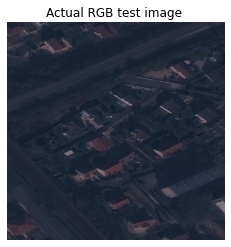

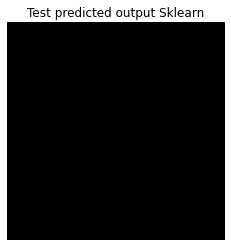

In [43]:
with rOpen('data/test/test_input.tif', 'r') as test_input_ds:
    test_input_image_ndarray = test_input_ds.read()  # read all raster values


test_input_image_ndarray_2D = np.reshape(test_input_image_ndarray, (8, -1))

test_input_2D = normalize_input_image(test_input_image_ndarray_2D, training_input_image_ndarray_2D)

normalised_test_input_image_ndarray = np.reshape(test_input_2D, (8, 650, 650))

normalised_red_channel_test = normalised_test_input_image_ndarray[4]
normalised_green_channel_test = normalised_test_input_image_ndarray[2]
normalised_blue_channel_test = normalised_test_input_image_ndarray[1]


normalised_rgb_test_ndarray = np.dstack(
    (
        normalised_red_channel_test,
        normalised_green_channel_test,
        normalised_blue_channel_test
    )
)

logistic_test_data_before_transpose = np.reshape(normalised_test_input_image_ndarray, (8, -1))
logistic_test_data = logistic_test_data_before_transpose.T

logistic_test_pred = logisticRegression_sklearn.predict(logistic_test_data)
logistic_test_predicted_imageSklearn = np.reshape(logistic_test_pred, (650, 650))


plt.imshow(normalised_rgb_test_ndarray, cmap="Greys_r")
plt.title("Actual RGB test image ")
plt.axis("off")
plt.show()


plt.imshow(logistic_test_predicted_imageSklearn, cmap="Greys_r")
plt.title("Test predicted output Sklearn")
plt.axis("off")
plt.show()


Due to the plots above being pretty much all black, as the threshold of 0.5 is too strong at the moment, it appeared more appropriate to make use of the the actual non-clipped values of the logistic regression model to see better it's predictions for what is a rooftop and what isn't a rooftop.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


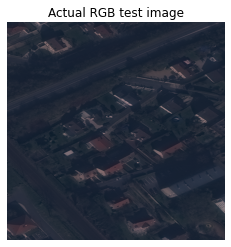

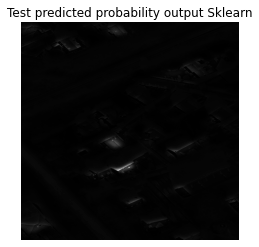

In [44]:
logistic_test_pred_proba = logisticRegression_sklearn.predict_proba(logistic_test_data)[:,1]
logistic_test_predicted_proba_imageSklearn = np.reshape(logistic_test_pred_proba, (650, 650))


plt.imshow(normalised_rgb_test_ndarray, cmap="Greys_r")
plt.title("Actual RGB test image")
plt.axis("off")
plt.show()

plt.imshow(logistic_test_predicted_proba_imageSklearn, cmap="Greys_r")
plt.title("Test predicted probability output Sklearn")
plt.axis("off")
plt.show()

In [45]:
np.max(logistic_test_pred_proba)

0.07230432215844357

[86.98627219 13.01372781]


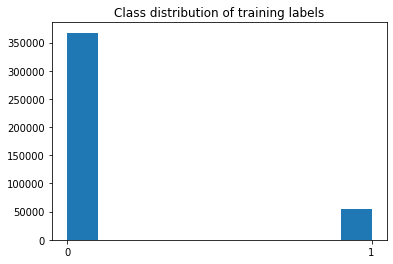

In [46]:
unique_classes, counts = np.unique(logistic_train_target, return_counts=True)

# get the perecentage of values
class_percentages = (counts/np.sum(counts))*100
print(class_percentages)

plt.title("Class distribution of training labels")
plt.xticks([0,1])
plt.hist(logistic_train_target)
plt.show()

It is much easier to see what the model thinks by overlaying both images over each other. The brighter areas on the plot below emphasises the model highlighting the rooftops with a particular emphasises on the one in the middle where there are even more colours present reddish/orange/green areas. And as seen in the calculation above, the maximum output the model gives is less than 0.1 which emphasises the point that the threshold of the vanilla logistic regression model (0.5) is too strong. My perspective on it being too strong is due to the huge class imbalance (see the simple plot above) biasing the outputs to 0 (non-rooftop class).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


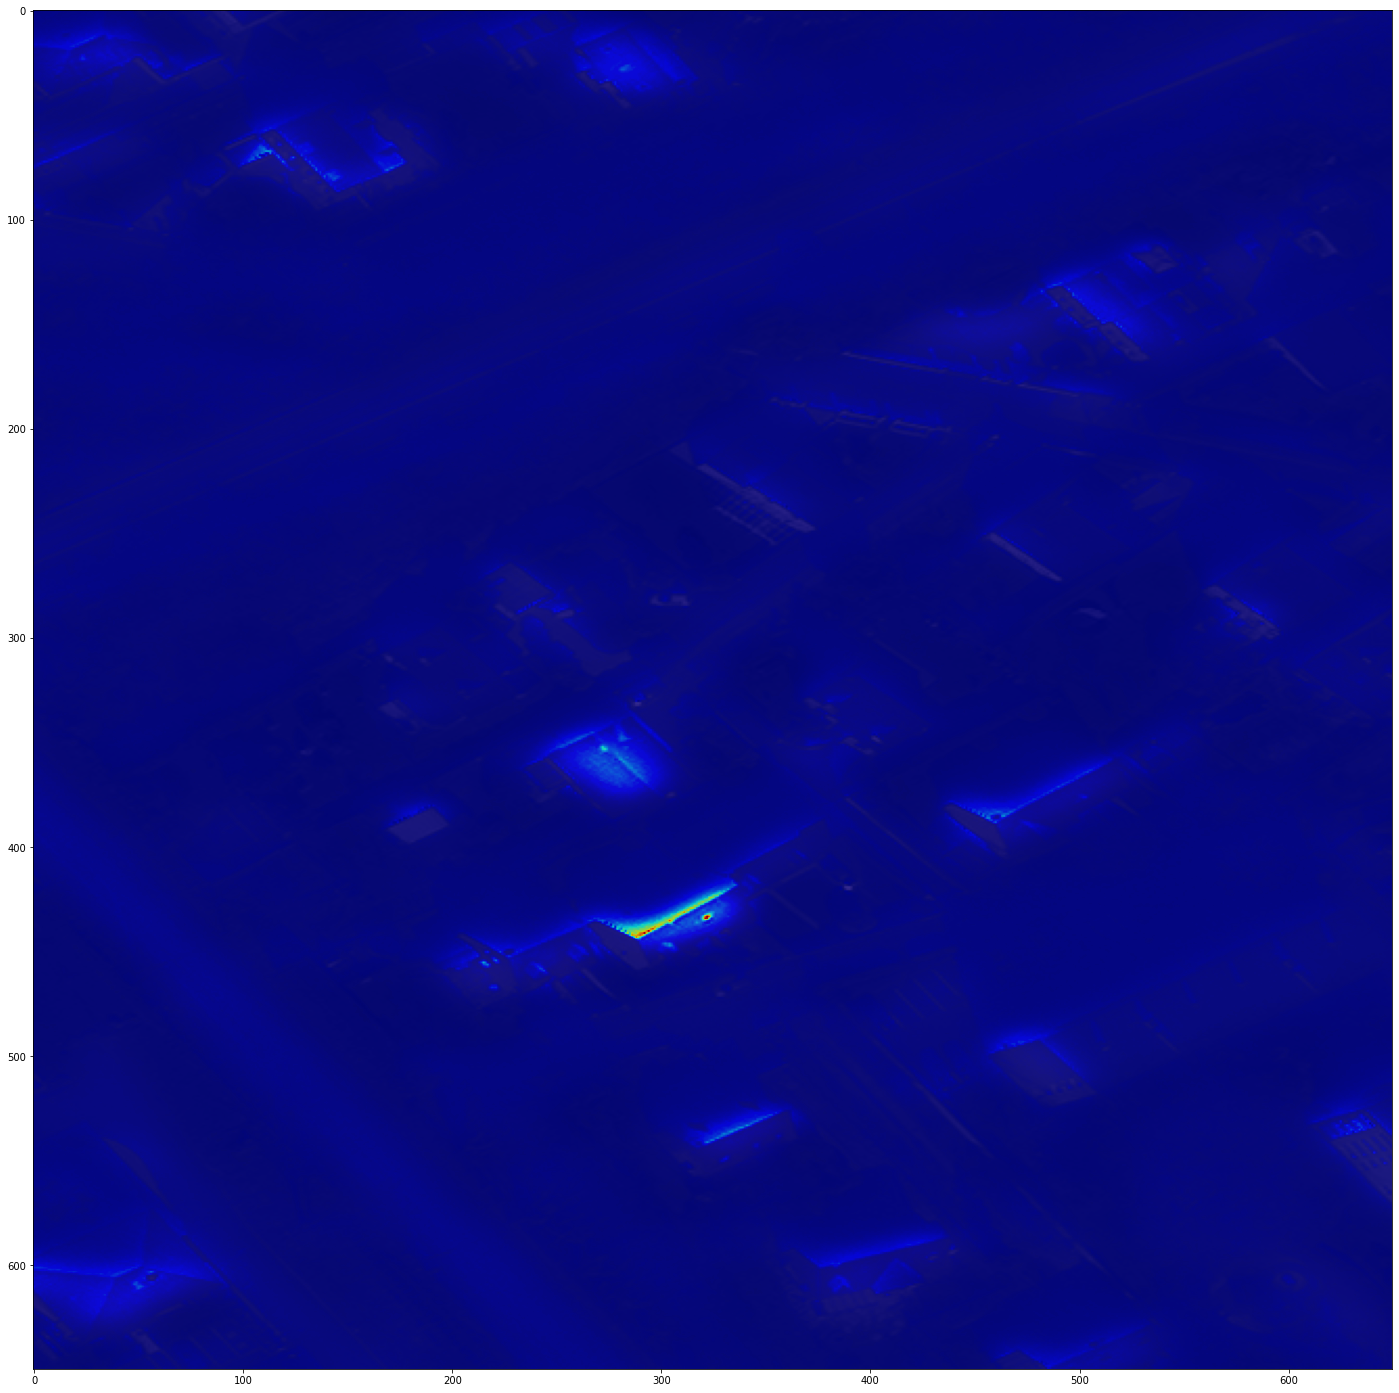

In [47]:
plt.figure(figsize=(25, 25))
plt.imshow(normalised_rgb_test_ndarray, cmap="jet")
plt.imshow(logistic_test_predicted_proba_imageSklearn, cmap="jet", alpha=0.8)
plt.show()

2. (e) Visualize the trained parameters of your trained model as a 1-d vector. Explain the values and
describe how they affect the behavior of your binary classifier?

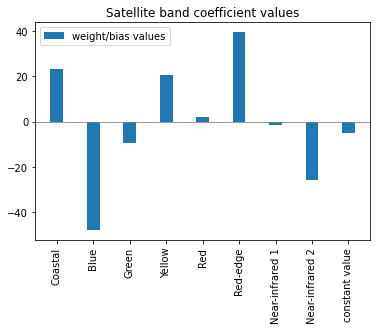

In [48]:
N = 9
list_of_values = sklearn_paramters
ind = np.arange(N) # the x locations for the groups
width = 0.35 # the width of the bars: can also be len(x) sequence


fig, ax = plt.subplots()
p1 = ax.bar(ind, list_of_values, width, label='weight/bias values')
ax.axhline(0, color='grey', linewidth=0.8)

ax.set_title('Satellite band coefficient values')
ax.set_xticks(ind)
ax.set_xticklabels(('Coastal', 'Blue', 'Green', 'Yellow', 'Red', 'Red-edge', 'Near-infrared 1', 'Near-infrared 2', 'constant value'))
ax.legend()
plt.xticks(rotation=90)
plt.show()


There are various observations that can be made here but I'll try to restrict it to ones that stand out to me currently. 
Generally speaking, there are 2 groups here. The parameters which have positive values and ones with negative values.
Increasing the presence/intensity of the positive group, ie values like red-edge, coastal and so on for a given pixel would cause the binary classifier to more likely suggest that that given pixel is a rooftop and vice versa reducing the intensity of these values would make the classifier lean more towards the no-rooftop class
The opposite appears to hold true for the negative weighted satellite bands and the bias (like Blue, near-infrared 2 and so on).
Finally, focusing on the magnitude of the satellite bands, it can be seen that the impact of the blue satellite band and red-edge satellite band seems to overpower the other values, making them strong indicators of no-rooftop and rooftop respectively. On the other hand, satellite bands like Red and Near-infrared1 seem to have little to no effect on the binary classifier's choice (of rooftop/no-rooftop).

# Convolutional neural network

3. (a) Define a CNN with the layers specified in the pdf

In [49]:
# !pip install tensorflow

# after running this restart the kernel and move to the next cell and comment the line above

In [50]:
# import the needed libraries
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from keras import backend as K



In [51]:
cnn_model = Sequential()
cnn_model.add( Conv2D(32, kernel_size=(3,3), activation='relu'))
cnn_model.add( Conv2D(1, kernel_size=(3,3), activation='linear'))

3. (b) How many trainable parameters does your CNN model have? Describe your calculation.

The CNN model has 2,625 trainable parameters, if biases are included. The reason for this is as follows.

In the first layer, each 3 by 3 filter is applied to each satellite band of the input, there are 8 of them which results in (3 x 3) x 8.
There are 32 filters so it becomes ((3 x 3) x 8) x 32). In this formulation I assume there are biases which means adding 1 extra parameter to each of the 32 filters resulting in (((3 x 3) x 8) x 32) + 32.

For the second layer, a similar approach is done except instead of an input having 8 channels, here it has 32 channels resulting in (3 x 3) x 32. In this layer only one filter is required so it becomes ( ((3 x 3) x 32) x 1) and including the bias for that 1 filter results in ( ((3 x 3) x 32) x 1) + 1
So in total the total number of trainable parameters are ((((3 x 3) x 8) x 32) + 32) + ( ( ((3 x 3) x 32) x 1) + 1 ) which equals to 2336 + 289 which results in 2625 trainable parameters

3. (c) Initialize your CNN with random weights. Do not train your CNN. To ensure model input
dimensions are correct, apply the initial randomized model to the normalized training input image.

In [52]:
# build model
cnn_model_random_weights = Sequential()
cnn_model_random_weights.add( Conv2D(32, kernel_size=(3,3), activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform') )
cnn_model_random_weights.add( Conv2D(1, kernel_size=(3,3), activation='linear', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform') )


# ensure data is represented in a way Keras appreciates (1,650,650,8)
channel_last_normalised_training_input_image_ndarray = np.transpose(normalised_training_input_image_ndarray, (1,2,0))
added_axis_channel_last_normalised_training_input_image_ndarray = np.reshape(channel_last_normalised_training_input_image_ndarray, (1,650,650,8))



In [53]:
# apply model with randomly initialised weights
cnn_model_random_weights(added_axis_channel_last_normalised_training_input_image_ndarray)

<tf.Tensor: shape=(1, 646, 646, 1), dtype=float32, numpy=
array([[[[0.24181214],
         [0.24181214],
         [0.24181214],
         ...,
         [0.42853913],
         [0.4165867 ],
         [0.40812796]],

        [[0.24181214],
         [0.24181214],
         [0.24181214],
         ...,
         [0.40279126],
         [0.38796252],
         [0.3972078 ]],

        [[0.24181214],
         [0.24181214],
         [0.24181214],
         ...,
         [0.39645857],
         [0.40499222],
         [0.40007722]],

        ...,

        [[0.24181214],
         [0.24181214],
         [0.24181214],
         ...,
         [0.39493036],
         [0.3963482 ],
         [0.34454334]],

        [[0.24181214],
         [0.24181214],
         [0.24181214],
         ...,
         [0.38131323],
         [0.35208666],
         [0.33898175]],

        [[0.24181214],
         [0.24181214],
         [0.24181214],
         ...,
         [0.35507166],
         [0.33686757],
         [0.36843097]]]], dty

In [54]:
print("Helps to emphasise trainable parameter calculation above")
print(cnn_model_random_weights.summary())


Helps to emphasise trainable parameter calculation above
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (1, 648, 648, 32)         2336      
                                                                 
 conv2d_7 (Conv2D)           (1, 646, 646, 1)          289       
                                                                 
Total params: 2,625
Trainable params: 2,625
Non-trainable params: 0
_________________________________________________________________
None


Additional comments: I only initialised the biases to glorot uniform because the question mentioned to initialise with random weights. I feel like it would have been more appropriate to initialise the bias with a value that was either 0 or close to 0

3. (d) Suppose another, hypothetical, CNN classifier takes planar RGB images as input. Suppose the
input layer contains multiple 3x11x11 convolution filters. After training, the filters of the input layer
are visualized and one of them appears as (see pdf). In general terms, describe the role for which this filter has become trained.

This filter has diagonalish parallel lines going from orange to blue and vice versa. Looking at the training input image as an example, there is a presence of reddish-orange rooftops in a line with backgrounds like bluey-black roads or blue swimming pools separating them. As there are multiple filters, it could be that some training inputs might have houses and streets that are more in the orientation described in the filter than the vertical orientation of the training input image.

To summarise, more generally, it appears like this filter detects the presence of diagonal alligned houses or streets from the input.